In [1]:
import io
from IPython.nbformat import current
def execute_notebook(nbfile):
    with io.open(nbfile) as f:
        nb = current.read(f, 'json')
    ip = get_ipython()
    for cell in nb.worksheets[0].cells:
        if cell.cell_type != 'code':
            continue
        ip.run_cell(cell.input)
execute_notebook("../../../bin/imports.ipynb")
execute_notebook("/cellar/users/ramarty/Projects/hla_ii/bin/gathering_affinities.ipynb")

/cellar/users/ramarty/anaconda/lib/python2.7/site-packages/IPython/nbformat/current.py:19: UserWarning: IPython.nbformat.current is deprecated.

- use IPython.nbformat for read/write/validate public API
- use IPython.nbformat.vX directly to composing notebooks of a particular version

  """)
/cellar/users/ramarty/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Populating the interactive namespace from numpy and matplotlib


In [2]:
merged = gather_protein_sequences_all()

/cellar/users/ramarty/anaconda/lib/python2.7/site-packages/Bio/Seq.py:341: BiopythonDeprecationWarning: This method is obsolete; please use str(my_seq) instead of my_seq.tostring().
  BiopythonDeprecationWarning)


In [3]:
amp_genes = [x.strip() for x in open('/cellar/users/ramarty/Data/hla_ii/generated_data/mutations/amplified_genes.txt').readlines()]
del_genes = [x.strip() for x in open('/cellar/users/ramarty/Data/hla_ii/generated_data/mutations/deleted_genes.txt').readlines()]

Make Fasta Files

In [29]:
def get_peptides(gene_list):
    peptides = []
    for gene in gene_list:
        lengths = []
        for x in list(merged[merged.gene == gene].sequence):
            lengths.append(len(x))
        tmp = pd.DataFrame({'gene': list(merged[merged.gene == gene].sequence),
                            'length': lengths})
        peptides.append(list(tmp.sort_values('length', ascending=False).gene)[0])
    return peptides

In [24]:
def output_fasta(category, peptides, genes):
    out_file = '/cellar/users/ramarty/Data/hla_ii/presentation/whole_gene/fasta_files/{0}.fa'.format(category)
    print category
    with open(out_file, 'w') as outfile:
        for mutation, sequence in zip(genes, peptides):
            outfile.write('>{0}\n'.format(mutation))
            outfile.write('{0}\n'.format(sequence))
        
    return len(genes)

In [30]:
category = 'amplified'
peptides = get_peptides(amp_genes)
output_fasta(category, peptides, amp_genes)

amplified


10

In [31]:
category = 'deleted'
peptides = get_peptides(del_genes)
output_fasta(category, peptides, del_genes)

deleted


10

Run presentation

In [32]:
alleles = [x.strip() for x in open('/cellar/users/ramarty/Data/hla_ii/presentation/other/netMHCIIpan_alleles.txt').readlines() if x.strip()[:2] != 'H-']
len(alleles)

5620

In [33]:
def create_cluster_script_gather(alleles, category):

    categories = [category for x in alleles]
    new_script_file = '/cellar/users/ramarty/Projects/hla_ii/data_gathering/affinities/netmhcpanII.{0}.sh'.format(category)

    print category
    
    with open(new_script_file, 'w') as out_file:
        out_file.write("#! /bin/csh\n")
        out_file.write("#$ -V\n")
        out_file.write("#$ -S /bin/csh\n")
        out_file.write("#$ -o /cellar/users/ramarty/Data/hla_ii/sge-system_files\n")
        out_file.write("#$ -e /cellar/users/ramarty/Data/hla_ii/sge-system_files\n")
        out_file.write("#$ -cwd\n")
        out_file.write("#$ -t 1-{0}\n".format(len(alleles)))
        #out_file.write("#$ -t 1-2\n".format(len(samples)))
        out_file.write("#$ -l h_vmem=1G\n")
        out_file.write("#$ -tc 50\n")
        out_file.write("#$ -l long")
        out_file.write("\n")

        out_file.write("set alleles=({0})\n".format(" ".join(alleles)))
        out_file.write("set categories=({0})\n".format(" ".join(categories)))
        out_file.write("\n")

        out_file.write("set allele=$alleles[$SGE_TASK_ID]\n")
        out_file.write("set category=$categories[$SGE_TASK_ID]\n")
        out_file.write("\n")

        out_file.write("date\n")
        out_file.write("hostname\n")
        out_file.write("mkdir /cellar/users/ramarty/Data/hla_ii/presentation/whole_gene/affinities/$category\n")
        out_file.write("\n")

        out_file.write("echo starting netMHCIIpan\n")
        out_file.write("/cellar/users/ramarty/programs/netMHCIIpan-3.1/netMHCIIpan -f " \
                    + "/cellar/users/ramarty/Data/hla_ii/presentation/whole_gene/fasta_files/$category.fa -a $allele -xls -xlsfile " \
                    + "/cellar/users/ramarty/Data/hla_ii/presentation/whole_gene/affinities/$category/$allele.csv > " \
                    + "/cellar/users/ramarty/Data/hla_ii/sge-system_files/$category.$allele.txt\n")
        out_file.write("\n")
                       
        out_file.write("date\n")

In [34]:
create_cluster_script_gather(alleles, 'amplified')

amplified


In [35]:
create_cluster_script_gather(alleles, 'deleted')

deleted


Parse

In [18]:
def create_cluster_script_parse(categories, genes):

    new_script_file = '/cellar/users/ramarty/Projects/hla_ii/data_gathering/affinities/parse_genes.sh'
    
    with open(new_script_file, 'w') as out_file:
        out_file.write("#! /bin/csh\n")
        out_file.write("#$ -V\n")
        out_file.write("#$ -S /bin/csh\n")
        out_file.write("#$ -o /cellar/users/ramarty/Data/hla_ii/sge-system_files\n")
        out_file.write("#$ -e /cellar/users/ramarty/Data/hla_ii/sge-system_files\n")
        out_file.write("#$ -cwd\n")
        out_file.write("#$ -t 1-{0}\n".format(len(genes)))
        #out_file.write("#$ -t 1-2\n".format(len(samples)))
        out_file.write("#$ -l h_vmem=1G\n")
        out_file.write("#$ -tc 50\n")
        out_file.write("#$ -l long")
        out_file.write("\n")

        out_file.write("set genes=({0})\n".format(" ".join(genes)))
        out_file.write("set categories=({0})\n".format(" ".join(categories)))
        out_file.write("\n")

        out_file.write("set gene=$genes[$SGE_TASK_ID]\n")
        out_file.write("set category=$categories[$SGE_TASK_ID]\n")
        out_file.write("\n")

        out_file.write("date\n")
        out_file.write("hostname\n")
        out_file.write("\n")

        out_file.write("python /cellar/users/ramarty/Projects/hla_ii/data_gathering/affinities/creating_allele_matrices.gene.py $category $gene\n")
        out_file.write("\n")
                       
        out_file.write("date\n")

In [19]:
categories = ['amplified' for x in amp_genes] + ['deleted' for x in del_genes]
genes = amp_genes + del_genes
create_cluster_script_parse(categories, genes)

In [20]:
genes

['ERBB2',
 'TERT',
 'WNK1',
 'KDM5A',
 'IQSEC3',
 'EGFR',
 'B4GALNT3',
 'GOLPH3L',
 'SLC6A12',
 'ENSA',
 'CSMD1',
 'LPAR6',
 'PTPRD',
 'PDE4D',
 'WWOX',
 'CDKN2A',
 'LRP1B',
 'RB1',
 'CCSER1',
 'KLLN']

Patient matrices

In [30]:
def create_cluster_script_parse(categories, genes):

    population = 'TCGA'
    subset = 'inclusive'
    new_script_file = '/cellar/users/ramarty/Projects/hla_ii/data_gathering/affinities/patient_genes.sh'
    
    with open(new_script_file, 'w') as out_file:
        out_file.write("#! /bin/csh\n")
        out_file.write("#$ -V\n")
        out_file.write("#$ -S /bin/csh\n")
        out_file.write("#$ -o /cellar/users/ramarty/Data/hla_ii/sge-system_files\n")
        out_file.write("#$ -e /cellar/users/ramarty/Data/hla_ii/sge-system_files\n")
        out_file.write("#$ -cwd\n")
        out_file.write("#$ -t 1-{0}\n".format(len(genes)))
        #out_file.write("#$ -t 1-2\n".format(len(samples)))
        out_file.write("#$ -l h_vmem=1G\n")
        out_file.write("#$ -tc 50\n")
        out_file.write("#$ -l long")
        out_file.write("\n")

        out_file.write("set genes=({0})\n".format(" ".join(genes)))
        out_file.write("set categories=({0})\n".format(" ".join(categories)))
        out_file.write("\n")

        out_file.write("set gene=$genes[$SGE_TASK_ID]\n")
        out_file.write("set category=$categories[$SGE_TASK_ID]\n")
        out_file.write("\n")

        out_file.write("date\n")
        out_file.write("hostname\n")
        out_file.write("\n")

        out_file.write("python /cellar/users/ramarty/Projects/hla_ii/data_gathering/affinities/creating_patient_matrices.classII.genes.py $category $gene {0} {1}\n".format(population, subset))
        out_file.write("\n")
                       
        out_file.write("date\n")

In [31]:
categories = ['amplified' for x in amp_genes] + ['deleted' for x in del_genes]
genes = amp_genes + del_genes
create_cluster_script_parse(categories, genes)

View results

In [12]:
PHBR_scores, conditions, genes = [], [], []
for condition, gene_list in zip(['amplified', 'deleted'], [amp_genes, del_genes]):
    for gene in gene_list:
        df = pd.read_csv('/cellar/users/ramarty/Data/hla_ii/presentation/whole_gene/patient_matrices/{0}.{1}.TCGA.inclusive.csv'.format(condition, gene),
                    index_col=0)
        scores = list(df.median(axis=1))
        PHBR_scores.extend(scores)
        conditions.extend([condition for x in scores])
        genes.extend([gene for x in scores])
summary = pd.DataFrame({'Median PHBR per Residue': PHBR_scores,
                        'Condition': conditions,
                        'Gene': genes})

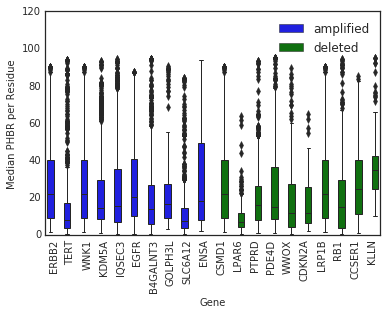

In [21]:
sns.boxplot(x='Gene', y='Median PHBR per Residue', data=summary, hue='Condition')
plt.xticks(rotation=90)
plt.legend(loc=1)
plt.ylim(0, 120)
plt.savefig('/cellar/users/ramarty/Data/hla_ii/generated_figures/copy_number/whole_genes.pdf', bbox_inches="tight")

In [15]:
summary.groupby('Condition').median()

,Median PHBR per Residue
Condition,
amplified,14.814425
deleted,17.097875


In [13]:
sp.mannwhitneyu(summary[summary.Condition == 'amplified']['Median PHBR per Residue'],
                summary[summary.Condition == 'deleted']['Median PHBR per Residue'])

MannwhitneyuResult(statistic=38775744.0, pvalue=0.00015181205910735028)

In [7]:
# min
PHBR_scores, conditions, genes = [], [], []
for condition, gene_list in zip(['amplified', 'deleted'], [amp_genes, del_genes]):
    for gene in gene_list:
        df = pd.read_csv('/cellar/users/ramarty/Data/hla_ii/presentation/whole_gene/patient_matrices/{0}.{1}.TCGA.inclusive.csv'.format(condition, gene),
                    index_col=0)
        scores = list(df.min(axis=1))
        PHBR_scores.extend(scores)
        conditions.extend([condition for x in scores])
        genes.extend([gene for x in scores])
summary = pd.DataFrame({'Median PHBR per Residue': PHBR_scores,
                        'Condition': conditions,
                        'Gene': genes})

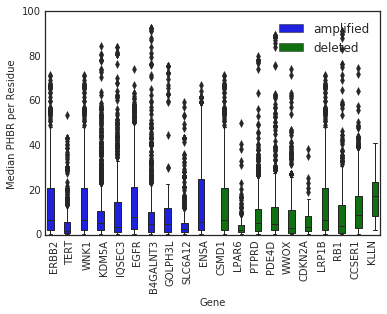

In [8]:
sns.boxplot(x='Gene', y='Median PHBR per Residue', data=summary, hue='Condition')
plt.xticks(rotation=90)
plt.legend(loc=1)
#plt.ylim(0, 120)
#plt.savefig('/cellar/users/ramarty/Data/hla_ii/generated_figures/copy_number/whole_genes.pdf', bbox_inches="tight")

In [10]:
summary.groupby('Condition').describe()

Median PHBR per Residue
Condition                               
amplified count              9808.000000
          mean                 10.464582
          std                  14.007361
          min                   0.023965
          25%                   1.513966
          50%                   4.621361
          75%                  13.454315
          max                  92.334569
deleted   count              8162.000000
          mean                 10.412078
          std                  13.020741
          min                   0.026594
          25%                   1.683257
          50%                   5.316640
          75%                  14.243266
          max                  91.415094

In [11]:
sp.mannwhitneyu(summary[summary.Condition == 'amplified']['Median PHBR per Residue'],
                summary[summary.Condition == 'deleted']['Median PHBR per Residue'])

MannwhitneyuResult(statistic=38793950.0, pvalue=0.00018570477040175026)